In [111]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
data = pd.read_pickle('master_df_gw_hdd.pkl')

In [6]:
#get only noon forecast
data['hour'] = data.index.hour
data = data[data['hour'] == 12]
data.drop('hour', axis=1, inplace=True)

/var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/ipykernel_38758/4125456460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('hour', axis=1, inplace=True)


In [14]:
display(data.columns)

Index(['gfs-ens-bc_9', 'gfs-ens-bc_10', 'gfs-ens-bc_11', 'gfs-ens-bc_12',
       'gfs-ens-bc_13', 'gfs-ens-bc_14', 'cmc-ens_9', 'cmc-ens_10',
       'cmc-ens_11', 'cmc-ens_12', 'cmc-ens_13', 'cmc-ens_14', 'ecmwf_diff_8',
       'ecmwf_diff_9', 'day_8_error', 'error_9', 'error_10', 'error_11',
       'error_12', 'error_13', 'error_14', 'noon', 'ecmwf-eps_9',
       'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12', 'ecmwf-eps_13',
       'ecmwf-eps_14'],
      dtype='object')

In [9]:
# betas for hdd
b1 = 0.76947604258751
b2 = 0.6555933110283885
b3 = 0.16964083221789059
b4 = 0.06680336217511197

### model


In [226]:
y = data[['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12', 'ecmwf-eps_13', 'ecmwf-eps_14']].mean(axis=1)
x1 = data['day_8_error']
x2 = data[['ecmwf_diff_8', 'ecmwf_diff_9']].mean(axis=1)
x3 = data[['gfs-ens-bc_11', 'gfs-ens-bc_12', 'gfs-ens-bc_13', 'gfs-ens-bc_14']].mean(axis=1)
x4 = data[['cmc-ens_9', 'cmc-ens_10', 'cmc-ens_11', 'cmc-ens_12', 'cmc-ens_13', 'cmc-ens_14']].mean(axis=1)

In [227]:
X = pd.concat([x1, x2, x3, x4], axis=1)
X.columns = ['x1', 'x2', 'x3', 'x4']

In [228]:
preds = (b1*x1)+(b2*x2)+(b3*x3)+(b4*x4)

In [229]:
mse = mean_squared_error(y, preds)

In [230]:
mse

2.3312943940709294

In [231]:
errors = y - preds

In [232]:
errors = errors.to_frame()
errors['ds'] = errors.index
errors.rename(columns={0:'y'}, inplace=True)
errors.reset_index(drop=True, inplace=True)

In [233]:
train_len = 0.85
train_errors = errors.iloc[:int(len(errors)*train_len)]
test_errors = errors.iloc[int(len(errors)*train_len):]

In [234]:
train_errors

,y,ds
0,-0.046690,2018-07-11 12:00:00
1,-0.004476,2018-07-12 12:00:00
2,-0.001798,2018-07-13 12:00:00
3,-0.000495,2018-07-14 12:00:00
4,-0.001534,2018-07-15 12:00:00
...,...,...
1480,-0.092820,2022-08-22 12:00:00
1481,-0.008458,2022-08-23 12:00:00
1482,-0.222097,2022-08-24 12:00:00
1483,-0.028557,2022-08-25 12:00:00


In [235]:
m = Prophet()
m.fit(train_errors)

14:13:09 - cmdstanpy - INFO - Chain [1] start processing
14:13:09 - cmdstanpy - INFO - Chain [1] done processing


In [236]:
future = m.make_future_dataframe(periods=263)
future.tail()

,ds
1743,2023-05-12 12:00:00
1744,2023-05-13 12:00:00
1745,2023-05-14 12:00:00
1746,2023-05-15 12:00:00
1747,2023-05-16 12:00:00


In [237]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1743,2023-05-12 12:00:00,-0.119869,-2.101448,1.862496
1744,2023-05-13 12:00:00,0.193532,-1.696720,2.045796
1745,2023-05-14 12:00:00,0.114590,-1.848855,1.939459
1746,2023-05-15 12:00:00,0.264464,-1.572638,2.169769
1747,2023-05-16 12:00:00,0.212759,-1.616155,2.083655


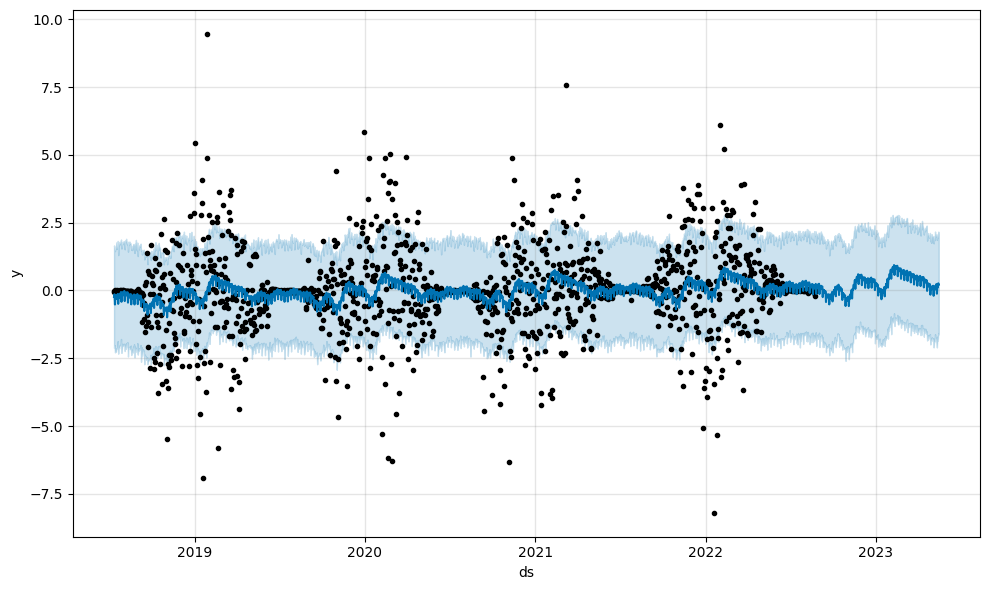

In [238]:
fig1 = m.plot(forecast)

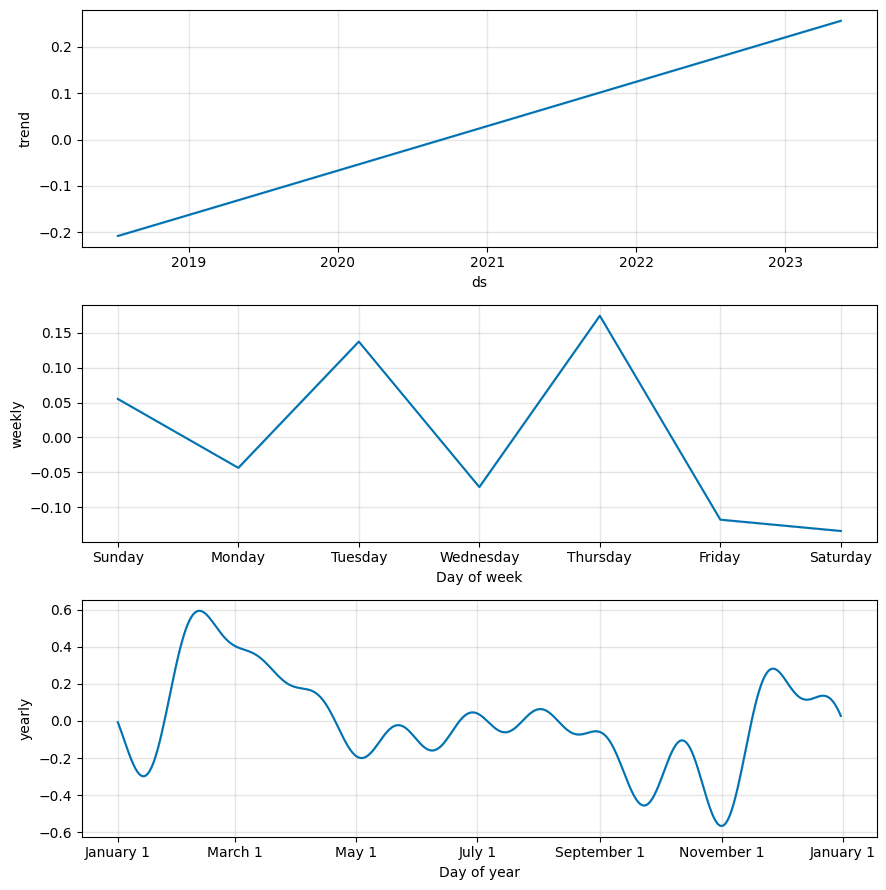

In [239]:
fig2 = m.plot_components(forecast)

In [240]:
forecasted_errors = forecast[['ds', 'yhat']]
forecasted_errors.set_index('ds', inplace=True)

In [241]:
# errors without adjustment
((preds - y) **2).mean()

2.3312943940709294

In [242]:
(((preds + forecasted_errors['yhat']) - y)**2).mean()

2.227221658298515

In [243]:
preds

2018-07-11 12:00:00    0.047357
2018-07-12 12:00:00    0.004642
2018-07-13 12:00:00    0.001964
2018-07-14 12:00:00    0.000495
2018-07-15 12:00:00    0.003534
                         ...   
2023-05-12 12:00:00   -2.213267
2023-05-13 12:00:00   -1.072859
2023-05-14 12:00:00   -0.249044
2023-05-15 12:00:00    0.332009
2023-05-16 12:00:00   -0.581538
Length: 1748, dtype: float64